In [14]:
import tkinter
import camelot
import pandas as pd
from IPython.display import display
import numpy as np
import re

### camelot.read_pdfで表を読み込む。

camelotはデフォルトでは１ページ目しか読み込まない。決算短信の営業利益は必ず１ページ目の最初の表に記されているため、１ページ目だけ読み込む設定のままでOK.<br>
layout_kwargs = {'char_margin': } の値を調整する（小さくとる）ことで、近い位置にある文字が同じセルにあると認識されることを防ぐ。<br>
小さい表や区切り線は無視されることがある。その場合はline_scaleを調整する。

In [151]:
tables = camelot.read_pdf('decrypted_PDFs/kessan33-3.pdf', line_scale=30, pages="1,2",
                          layout_kwargs = {'char_margin': 0.4}
                         ) # ,strip_text=' .\n', pages="all"

# tables.export('foo.csv', f='csv', compress=True) # json, excel, html, markdown, sqlite

In [152]:
def right_align(df):
    
    length = df.shape[1]

    # Noneを含む行を右に詰める
    for row in df.itertuples(name=None):
        shift = row.count(None)
        if shift > 0:
            index = row[0]
            for i in reversed(range(shift,length)):
                df.iloc[index,i] = df.iloc[index,i-shift]
            for i in range(shift):
                df.iloc[index,i] = None
    return df

In [153]:
def delete_words(x):
    x = str(x)
    x = re.sub("百万円\n", "",x)
    x = re.sub("(\%|\％)\n", "",x)
#     x = re.sub("\％\n", "",x)
    x = re.sub("円", "",x)
    x = re.sub("銭\n", "",x)
    return(x)

In [154]:
def extract_aligned_df(table):
    df = table.df
    df_cleaned=df.applymap(delete_words)
    
    clean_titles = lambda x: str(x).replace("\n", "") 
    df_cleaned.iloc[0]= df_cleaned.iloc[0].map(clean_titles) 
    
    # 扱いやすくするためにまず転置
    df_transposed = df_cleaned.T
    # 改行で分割し、新たな列を作成
    df_buffer = df_transposed[1].str.split('\n', expand=True)
    # 右詰め
    df_new = right_align(df_buffer)
    # 左端の列と合成
    df_new = pd.concat([df_transposed[0], df_new],axis=1)
    # 行番号を振り直す
    df_new.columns = range(df_new.shape[1])
    
    return df_new

### PDF1~2ページ目の表を抜き出して整形する。
対応しているのは、見出しが１行に収まっているもののみ。見出しが段組みされているものは整形できません。<br>
PDFの表から得たいのは営業利益と通期見通し（ある場合）。
基本的に一つ目の表に営業利益が含まれていて、見出しは１行であるため、営業利益の情報を得ることは可能。<br>
また、通期見通しは、「通期」の語がある表が存在する場合に読み取れば良い。通期見通しの表も、段組されていることはないため対応可能。


In [156]:
for table in tables:
    result = extract_aligned_df(table).T
    display(result)

,0,1,2,3,4,5,6,7,8
0,,売上高,,営業利益,,経常利益,,親会社株主に帰属する当期純利益,
1,2021年3月期,"1,035,898",△2.3,"136,925",△4.2,"138,990",△8.2,"74,681",△16.2
2,2020年3月期,"1,060,070",4.6,"142,858",9.7,"151,356",4.5,"89,080",△3.2


,0,1,2,3,4,5
0,,1株当たり当期純利益,潜在株式調整後1株当たり当期純利益,自己資本当期純利益率,総資産経常利益率,売上高営業利益率
1,2021年3月期,342.17,―,7.1,7.6,13.2
2,2020年3月期,408.14,―,8.8,8.5,13.5


,0,1,2,3,4
0,,総資産,純資産,自己資本比率,1株当たり純資産
1,2021年3月期,"1,864,179","1,229,824",58.1,"4,958.18"
2,2020年3月期,"1,815,121","1,172,494",57.0,"4,742.58"


,0,1,2,3,4
0,,営業活動によるキャッシュ・フロー,投資活動によるキャッシュ・フロー,財務活動によるキャッシュ・フロー,現金及び現金同等物期末残高
1,2021年3月期,"181,932","△48,536","△49,311","490,039"
2,2020年3月期,"175,559","△60,780","△48,209","406,479"


,0,1,2,3,4,5,6,7,8
0,,年間配当金,,,,,配当金総額（合計）,配当性向（連結）,純資産配当率（連結）
1,,第1四半期末,第2四半期末,第3四半期末,期末,合計,,,


,0,1,2,3,4,5,6,7,8,9
0,,売上高,,営業利益,,経常利益,,親会社株主に帰属する当期純利益,,1株当たり当期純利益
1,第2四半期(累計),"503,000",2.4,"63,000",3.7,"66,000",11.5,"39,500",22.1,180.98
2,通期,"1,052,000",1.6,"139,500",1.9,"145,000",4.3,"86,500",15.8,396.31


,0,1,2,3
0,2021年3月期,"233,295,926 株",2020年3月期,"233,293,998 株"
1,2021年3月期,"15,034,565 株",2020年3月期,"15,033,588 株"


,0,1,2,3,4,5,6,7,8
0,,売上高,,営業利益,,経常利益,,当期純利益,
1,2021年3月期,"394,389",△1.1,"75,541",△1.7,"89,301",△1.4,"59,960",△8.9
2,2020年3月期,"398,929",1.2,"76,877",0.1,"90,538",1.8,"65,808",△11.1


,0,1,2
0,,1株当たり当期純利益,潜在株式調整後1株当たり当期純利益
1,2021年3月期,274.72,―
2,2020年3月期,301.51,―


,0,1,2,3,4
0,,総資産,純資産,自己資本比率,1株当たり純資産
1,2021年3月期,"971,493","838,562",86.3,"3,842.01"
2,2020年3月期,"947,194","812,878",85.8,"3,724.35"


### 一つ目の表において、営業利益を抽出して表示
row1 と row2 にデータが入っていることを前提にした処理。

In [262]:
df_rieki = extract_aligned_df(tables[0]).T

eigyo_rieki_i = df_rieki.loc[0].values.tolist().index("営業利益")
row = df_rieki[0].to_dict()
# row = dict(map(reversed,row.items()))

ratest = df_rieki.iloc[1,eigyo_rieki_i]
ratest_diff = df_rieki.iloc[1,eigyo_rieki_i+1]
previous=df_rieki.iloc[2, eigyo_rieki_i]
previous_diff=df_rieki.iloc[2, eigyo_rieki_i+1]

print(str(row[1]),"の営業利益は",ratest,"百万円でした。")
if "△" in ratest_diff:
    print("減：　",ratest_diff[1:], "%")
else:
    print("増：　", ratest_diff, "%")

    
print(str(row[2]),"の営業利益は",previous,"百万円でした。")
if "△" in previous_diff:
    print("減：　",previous_diff[1:], "%")
else:
    print("増：　", previous_diff, "%")

2021年3月期 の営業利益は 136,925 百万円でした。
減：　 4.2 %
2020年3月期 の営業利益は 142,858 百万円でした。
増：　 9.7 %


### 「通期」の語がある表を探し、あった場合は通期営業利益を抽出して表示

In [263]:
tsuki_flg = False
for table in tables:
    # 通期を発見済みの場合はこれ以上探索しない
    if tsuki_flg == True:
        break
    df = extract_aligned_df(table).T
    # 列0 の要素に対して、"通期"を含むか否かのbooleanでリスト化
    binary_flg = df[0].str.contains("通期").values.tolist()
    # 通期Trueが存在した場合、何行目なのかを取得(tsuki_index)
    if True in binary_flg:
        tsuki_index = binary_flg.index(True)
        tsuki_flg = True
        display(df)
        # 行0 の値をリスト化し、”営業利益”が何列目なのかを取得(eigyo_rieki_index)
        eigyo_rieki_index = df.loc[0].values.tolist().index("営業利益")
        # tsuki_index, eigyo_rieki_index　のセルが通期営業利益。
        tsuki_eigyo_rieki = df.iloc[tsuki_index, eigyo_rieki_index]
        print("通期営業利益は：　", tsuki_eigyo_rieki, "百万円")
        
        # 隣のセルが増減を表す。
        tsuki_eigyo_rieki_diff = df.iloc[tsuki_index, eigyo_rieki_index+1]
        if "△" in tsuki_eigyo_rieki_diff:
            print("減：　", tsuki_eigyo_rieki_diff[1:], "%")
        else:
            print("増：　", tsuki_eigyo_rieki_diff, "%")


,0,1,2,3,4,5,6,7,8,9
0,,売上高,,営業利益,,経常利益,,親会社株主に帰属する当期純利益,,1株当たり当期純利益
1,第2四半期(累計),"503,000",2.4,"63,000",3.7,"66,000",11.5,"39,500",22.1,180.98
2,通期,"1,052,000",1.6,"139,500",1.9,"145,000",4.3,"86,500",15.8,396.31


通期営業利益は：　 139,500 百万円
増：　 1.9 %


### 実際にPDF中のどの部分を抜き出したか視覚的に表示

0番目に抽出された表



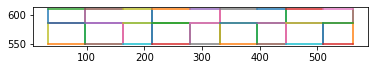

,0,1,2,3,4,5,6,7,8
0,,売上高,,営業利益,,経常利益,,親会社株主に帰属する当期\n純利益,
1,2021年3月期\n2020年3月期,"百万円\n1,035,898\n1,060,070",％\n△2.3\n4.6,"百万円\n136,925\n142,858",％\n△4.2\n9.7,"百万円\n138,990\n151,356",％\n△8.2\n4.5,"百万円\n74,681\n89,080",％\n△16.2\n△3.2


1番目に抽出された表



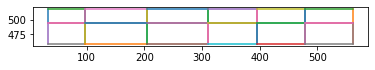

,0,1,2,3,4,5
0,,1株当たり当期純利益,潜在株式調整後1株当たり\n当期純利益,自己資本当期純利\n益率,総資産経常利益率,売上高営業利益率
1,2021年3月期\n2020年3月期,円 銭\n342.17\n408.14,円 銭\n―\n―,％\n7.1\n8.8,％\n7.6\n8.5,％\n13.2\n13.5


2番目に抽出された表



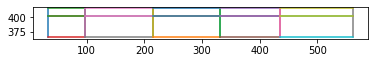

,0,1,2,3,4
0,,総資産,純資産,自己資本比率,1株当たり純資産
1,2021年3月期\n2020年3月期,"百万円\n1,864,179\n1,815,121","百万円\n1,229,824\n1,172,494",％\n58.1\n57.0,"円 銭\n4,958.18\n4,742.58"


3番目に抽出された表



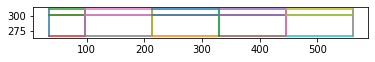

,0,1,2,3,4
0,,営業活動によるキャッシュ・フロー,投資活動によるキャッシュ・フロー,財務活動によるキャッシュ・フロー,現金及び現金同等物期末残高
1,2021年3月期\n2020年3月期,"百万円\n181,932\n175,559","百万円\n△48,536\n△60,780","百万円\n△49,311\n△48,209","百万円\n490,039\n406,479"


4番目に抽出された表



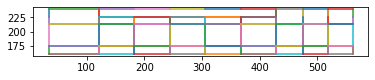

,0,1,2,3,4,5,6,7,8
0,,年間配当金,,,,,配当金総額\n（合計）,配当性向\n（連結）,純資産配当\n率（連結）
1,,第1四半期末,第2四半期末,第3四半期末,期末,合計,,,
2,2020年3月期\n2021年3月期,円 銭\n―\n―,円 銭\n85.00\n85.00,円 銭\n―\n―,円 銭\n85.00\n85.00,円 銭\n170.00\n170.00,"百万円\n37,104\n37,104",％\n41.7\n49.7,％\n3.7\n3.5
3,2022年3月期(予想),―,85.00,―,90.00,175.00,,44.2,


5番目に抽出された表



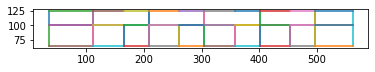

,0,1,2,3,4,5,6,7,8,9
0,,売上高,,営業利益,,経常利益,,親会社株主に帰属する\n当期純利益,,1株当たり当期\n純利益
1,第2四半期(累計)\n通期,"百万円\n503,000\n1,052,000",％\n2.4\n1.6,"百万円\n63,000\n139,500",％\n3.7\n1.9,"百万円\n66,000\n145,000",％\n11.5\n4.3,"百万円\n39,500\n86,500",％\n22.1\n15.8,円 銭\n180.98\n396.31


6番目に抽出された表



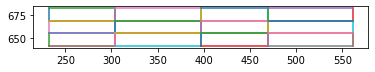

,0,1,2,3
0,2021年3月期,"233,295,926 株",2020年3月期,"233,293,998 株"
1,2021年3月期,"15,034,565 株",2020年3月期,"15,033,588 株"
2,2021年3月期,"218,261,353 株",2020年3月期,"218,260,796 株"


7番目に抽出された表



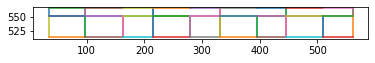

,0,1,2,3,4,5,6,7,8
0,,売上高,,営業利益,,経常利益,,当期純利益,
1,2021年3月期\n2020年3月期,"百万円\n394,389\n398,929",％\n△1.1\n1.2,"百万円\n75,541\n76,877",％\n△1.7\n0.1,"百万円\n89,301\n90,538",％\n△1.4\n1.8,"百万円\n59,960\n65,808",％\n△8.9\n△11.1


8番目に抽出された表



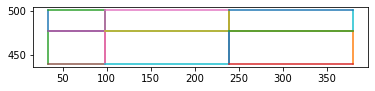

,0,1,2
0,,1株当たり当期純利益,潜在株式調整後1株当たり当期純\n利益
1,2021年3月期\n2020年3月期,円 銭\n274.72\n301.51,円 銭\n―\n―


9番目に抽出された表



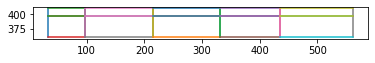

,0,1,2,3,4
0,,総資産,純資産,自己資本比率,1株当たり純資産
1,2021年3月期\n2020年3月期,"百万円\n971,493\n947,194","百万円\n838,562\n812,878",％\n86.3\n85.8,"円 銭\n3,842.01\n3,724.35"


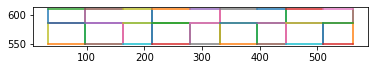

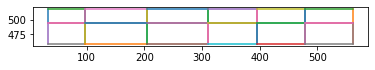

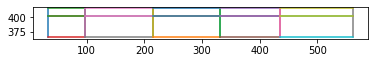

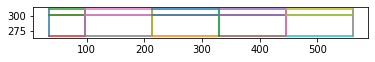

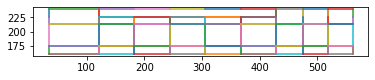

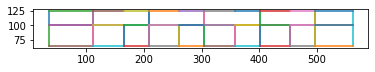

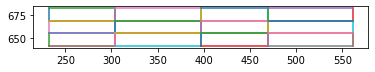

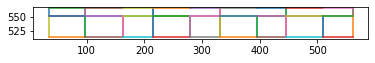

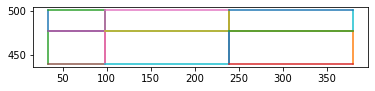

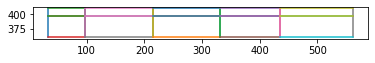

In [104]:
for i, table in enumerate(tables):
    print(f"{i}番目に抽出された表\n")
    display(camelot.plot(table, kind='grid'))
    display(table.df)

/var/folders/1c/zp6jf60x58g8vs33m9pjhswc0000gn/T/ipykernel_82140/1260959004.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='line').show()
/var/folders/1c/zp6jf60x58g8vs33m9pjhswc0000gn/T/ipykernel_82140/1260959004.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='contour').show()
/var/folders/1c/zp6jf60x58g8vs33m9pjhswc0000gn/T/ipykernel_82140/1260959004.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='joint').show()


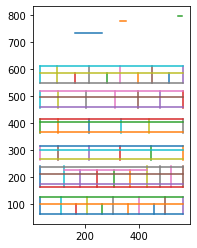

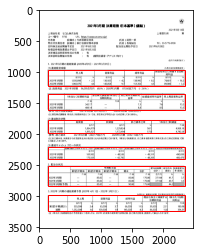

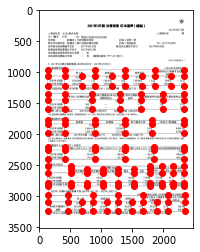

In [60]:
# ‘line’ and ‘joint’can only be used with Lattice and ‘textedge’can only be used with Stream.
camelot.plot(tables[0], kind='line').show()
camelot.plot(tables[0], kind='contour').show()
camelot.plot(tables[0], kind='joint').show()

camelotはデフォルトではlatticeモードで読み込む。以下ではstreamモードを試している。

In [91]:
tables_stream = camelot.read_pdf('decrypted_PDFs/kessan33-3.pdf', pages="1,2,3,4,5",flavor='stream', row_tol=10,edge_tol=1000,strip_text=' .\n')
tables_stream

<TableList n=5>

/var/folders/1c/zp6jf60x58g8vs33m9pjhswc0000gn/T/ipykernel_82140/3779798431.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables_stream[0],kind ="text").show()


,0
0,2021年3月期決算短信〔日本基準〕（連結）
1,2021年5月13日
2,東上場会社名セコム株式会社上場取引所
3,コード番号9735URLhttps://wwwsecomcojp/
4,代表者（役職名）代表取締役社長（氏名）尾関一郎
5,問合せ先責任者（役職名）執行役員財務本部長（氏名）長尾誠也TEL03-5775-8100
6,定時株主総会開催予定日2021年6月25日配当支払開始予定日2021年6月28日
7,有価証券報告書提出予定日2021年6月25日
8,決算補足説明資料作成の有無：有
9,決算説明会開催の有無：有（機関投資家・アナリスト向け）


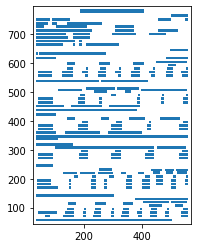

In [99]:
camelot.plot(tables_stream[0],kind ="text").show()
display(tables_stream[0].df)

/var/folders/1c/zp6jf60x58g8vs33m9pjhswc0000gn/T/ipykernel_82140/1443932262.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[2],kind='grid').show()


,0,1,2,3,4
0,,総資産,純資産,自己資本比率,1株当たり純資産
1,2021年3月期\n2020年3月期,"百万円\n1,864,179\n1,815,121","百万円\n1,229,824\n1,172,494",％\n58.1\n57.0,"円 銭\n4,958.18\n4,742.58"


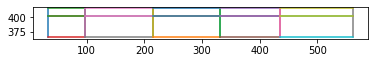

In [39]:
camelot.plot(tables[2],kind='grid').show()
tables[2].df